In [1]:
import pandas as pd
tables=pd.read_html("https://es.wikipedia.org/wiki/Anexo:Reportes_diarios_de_la_pandemia_de_COVID-19_en_Per%C3%BA")

In [2]:
tables[-1].head()

,Fecha,LIM,ARE,HUC,ICA,CUS,PIU,LAM,CAL,LAL,ANC,LOR,SAM,MDD,JUN,TUM,CAJ,PAS,TAC,AYA,HUA,APU,MOQ,PUN,AMA,UCA,Total,Acumulado,Ref.
0,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo,Hallazgo
1,6-3-2020,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,[362]​
2,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia,Contención de epidemia
3,7-3-2020,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,6,[363]​
4,8-3-2020,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,[364]​


In [3]:
df = tables[-1]
df = df.loc[~df['Fecha'].isin(['Hallazgo','Contención de epidemia','Transmisión comunitaria']),:]
df = df.iloc[:-2,:]
df.drop(['Total','Acumulado','Ref.'], axis=1, inplace=True)

In [4]:
pd.set_option('display.max_rows', df.shape[0]+1)
df.Fecha= pd.to_datetime(df.Fecha, format="%d-%m-%Y")

In [5]:
df.set_index('Fecha', inplace=True)

In [6]:
df.fillna(0, inplace = True)

In [7]:
df.head()

,LIM,ARE,HUC,ICA,CUS,PIU,LAM,CAL,LAL,ANC,LOR,SAM,MDD,JUN,TUM,CAJ,PAS,TAC,AYA,HUA,APU,MOQ,PUN,AMA,UCA
Fecha,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-06,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-07,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-08,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-09,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-10,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
num_dias = df.shape[0]
num_departamentos = df.shape[1]
print(f'[INFO] Existen {num_dias} días de información para {num_departamentos} departamentos.')

[INFO] Existen 355 días de información para 25 departamentos.


In [9]:
df = df.applymap(lambda x: int(str(x).split('[')[0]))

In [10]:
df.columns

Index(['LIM', 'ARE', 'HUC', 'ICA', 'CUS', 'PIU', 'LAM', 'CAL', 'LAL', 'ANC',
       'LOR', 'SAM', 'MDD', 'JUN', 'TUM', 'CAJ', 'PAS', 'TAC', 'AYA', 'HUA',
       'APU', 'MOQ', 'PUN', 'AMA', 'UCA'],
      dtype='object')

In [11]:
df.index = pd.to_datetime(df.index)

In [12]:
import matplotlib.pyplot as plt

In [13]:
df['PERU'] = df.sum(axis=1)

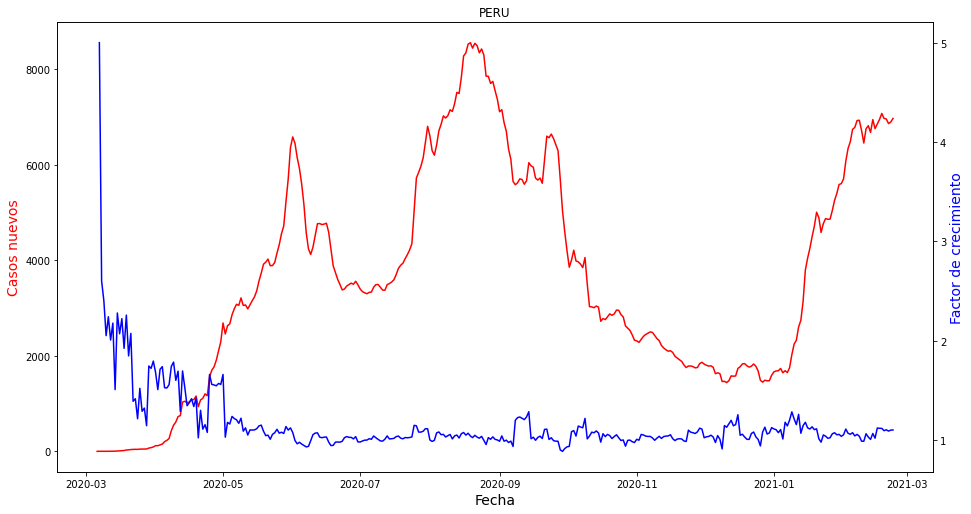

In [14]:
pd.options.mode.chained_assignment = None  # default='warn'
cols = ['PERU']#df.columns
for dept in cols:
  df_temp = df[[dept]]
  df_temp.columns = ['Casos nuevos']
  df_temp['SMA_7'] = df_temp['Casos nuevos'].rolling(7, min_periods=1).mean()
  df_temp['Acumulado'] = df_temp['Casos nuevos'].cumsum()
  df_temp['Factor de crecimiento'] = df_temp['Casos nuevos'] / df_temp['Casos nuevos'].shift(1)
  df_temp['Factor de crecimiento'] = df_temp['Factor de crecimiento'].fillna(axis = 0, method = 'ffill')
  #df_temp[['Casos nuevos','Acumulado']].plot()
  # create figure and axis objects with subplots()
  fig,ax = plt.subplots(figsize=(15.69,8.27))
  # make a plot
  ax.plot(df_temp.index, df_temp['SMA_7'], color="red")
  # set x-axis label
  ax.set_xlabel("Fecha",fontsize=14)
  # set y-axis label
  ax.set_ylabel("Casos nuevos",color="red",fontsize=14)
  # twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  # make a plot with different y-axis using second axis object
  ax2.plot(df_temp.index, df_temp['Factor de crecimiento'].rolling(7, min_periods=1).mean(),color="blue")
  ax2.set_ylabel("Factor de crecimiento",color="blue",fontsize=14)
  ax2.set_title(str(dept))
  plt.show()
  # save the plot as a file
  #fig.savefig(f'covid_{str(dept)}.jpg',
  #            format='jpeg',
  #            dpi=100,
  #            bbox_inches='tight')

In [15]:
max_date = df_temp.index.max()
import datetime
import numpy as np
sim_n = 180
fecha_new = pd.date_range(max_date+ datetime.timedelta(days=1),max_date+ datetime.timedelta(days=sim_n))
np.random.seed(72)
sd = np.std(df_temp['Casos nuevos'][-30:])
noise = pd.Series((np.random.normal(0, sd*0.5, fecha_new.shape[0]+10))).rolling(10, min_periods=1).mean().values[-fecha_new.shape[0]:]
dias_period = 15
period = 2* np.pi / dias_period #seteamos el periodo para que represente 15 días
casos_new = 0.5*sd*np.sin(period*np.arange(fecha_new.shape[0])) 
casos_new -= casos_new[0] 
casos_new += noise
casos_new += df_temp['Casos nuevos'][-1]

#plt.plot(fecha_new,casos_new)
fecha = df_temp.index
casos = df_temp['Casos nuevos']
fecha_tot = np.append(fecha, fecha_new)
#media movil ult 7 días
casos_tot = pd.Series(np.append(casos, casos_new)).rolling(7, min_periods=1).mean()

In [16]:
#Para el escenario 2 tomo que la caida si mantenemos la cuarentena es similar a la que ocurrió en el mes de octubre
descent = df_temp.loc['2020-09-24':'2020-10-24','Casos nuevos'].copy()
noise = pd.Series((np.random.normal(0, sd*0.5, descent.shape[0]+10))).rolling(10, min_periods=1).mean().values[-descent.shape[0]:]
descent -= noise
descent -= (descent[0] - df_temp['Casos nuevos'][-1])
fecha_new_2 = pd.date_range(max_date+ datetime.timedelta(days=1),max_date+ datetime.timedelta(days=descent.shape[0]))
fecha_tot_2 = np.append(fecha, fecha_new_2)
#media movil ult 7 días
casos_tot_2 = np.append(casos, descent)
fecha_new_3 = pd.date_range(fecha_new_2.max()+ datetime.timedelta(days=1),fecha_new_2.max()+ datetime.timedelta(days=sim_n-descent.shape[0]))
np.random.seed(70)
#agrego una oscilación sinusoidal para simular un periodo de aproxiamadamente 1 mes (unsa subida/bajada son 2 semanas).
noise = pd.Series((np.random.normal(0, sd*0.5, fecha_new_3.shape[0]+10))).rolling(10, min_periods=1).mean().values[-fecha_new_3.shape[0]:]
oscillate = 0.5*sd*np.sin(period*np.arange(fecha_new_3.shape[0]))
casos_new = oscillate 
casos_new -= casos_new[0] 
casos_new += noise
casos_new += casos_tot_2[-1]
fecha_tot_3 = np.append(fecha_tot_2, fecha_new_3)
casos_tot_3 = pd.Series(np.append(casos_tot_2, casos_new)).rolling(7, min_periods=1).mean()

Text(0.5, 0.95, '    Evolución de casos nuevos de Covid')

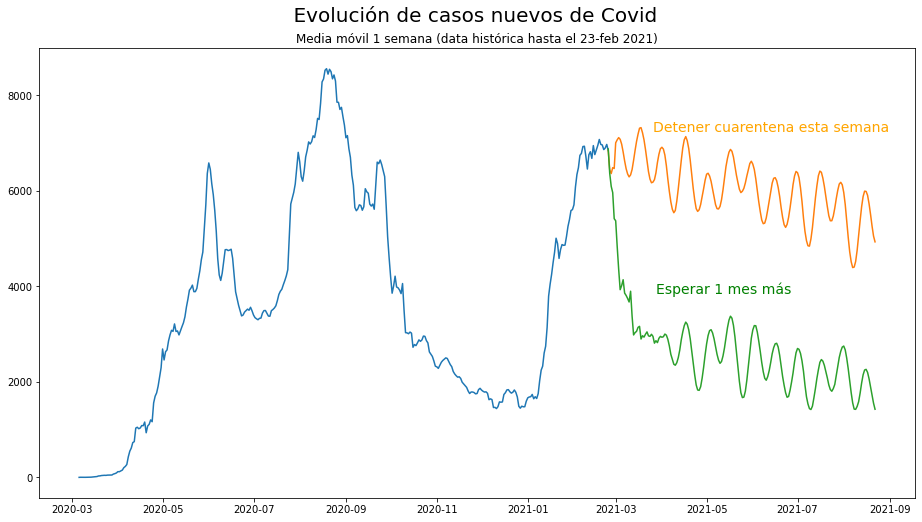

In [17]:
fig,ax = plt.subplots(figsize=(15.69,8.27))
ax.plot(fecha_tot[0:-(sim_n-1)],casos_tot[0:-(sim_n-1)])
# agrego una tendencia leve para simular que en general deberíamos ir en descenso por factores como el incremento de la vacunación
trend = np.arange(sim_n)*sd*0.005
ax.plot(fecha_tot[-sim_n:],casos_tot[-sim_n:]-trend)
ax.plot(fecha_tot_3[-sim_n:],casos_tot_3[-sim_n:]-trend)
ax.text(fecha_tot[-sim_n+30], casos_tot.values[-(sim_n+10):].max()-300, "Detener cuarentena esta semana",fontsize=14, color = "orange")
ax.text(fecha_tot_3[-sim_n+32], casos_tot_3.values[-(sim_n+10):].mean()+300, "Esperar 1 mes más",fontsize=14, color = "green")
ax.set_title('Media móvil 1 semana (data histórica hasta el 23-feb 2021)',fontsize=12)
fig.suptitle('    Evolución de casos nuevos de Covid',fontsize=20, y=0.95)